In [109]:
import os
import json
import pickle
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

pd.set_option('display.max_colwidth', 128)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [3]:
model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [4]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [5]:
# load questions

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [6]:
# tokenize inputs

tokenized = []

for idx, p in enumerate(prompts):
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt")
    p['pid'] = idx
    p['prompt'] = prompt
    p['tokenized'] = inputs
    tokenized.append(p)

Token indices sequence length is longer than the specified maximum sequence length for this model (4857 > 4096). Running this sequence through the model will result in indexing errors


In [7]:
%%time

prompt_lenghts = []

for p in tokenized:
    plen = p['tokenized']['input_ids'][0].shape[0]
    
    cand_len = len(p['question'].split('>,')) - 1
    cand_pos = [idx for idx, cand in enumerate(p['question'].split('>,')) if p['output'] in cand + '>']
    
    # extract candidates
    candidates = p['question'].split(',. What')[0].split('<')[1:]
    candidates = [c.replace('>,', '').replace('>', '') for c in candidates]
    
    candidates_clean = [c.replace('[DESCRIPTION] ', '').replace('[DESC] ', '').replace('[TYPE] ', '').lower() for c in candidates]
    candidates_clean = [c for c in candidates_clean if c]
    
    prompt_lenghts.append((p['pid'], len(p['prompt']), plen, cand_len, cand_pos, candidates, candidates_clean))

pl = pd.DataFrame(prompt_lenghts, columns=['pid', 'char_len', 'tok_len', 'cand_len', 'cand_pos', 'cand', 'cand_clean'])
pl['cand_pos_first'] = pl.cand_pos.str[0]

CPU times: user 141 ms, sys: 11.4 ms, total: 153 ms
Wall time: 148 ms


In [8]:
pl.cand_len

0       49
1       50
2       49
3       49
4       49
        ..
1796    50
1797    52
1798    50
1799    49
1800    49
Name: cand_len, Length: 1801, dtype: int64

In [9]:
truth

,run,pid,correct,hallucinated
0,0,9,False,False
1,0,10,False,False
2,0,12,False,False
3,0,14,False,False
4,0,17,True,False
...,...,...,...,...
3435,4,1788,True,False
3436,4,1789,True,False
3437,4,1790,False,False
3438,4,1794,True,False


In [10]:
a = answers.merge(pl, on='pid', how='left')
a['reconstructed'] = a.apply(lambda row: row['cand'][row['cand_pos_first']], axis=1)
a['correct'] = (a.answer.str.lower() == a.reconstructed.str.lower())

In [11]:
deb = a.merge(truth, on=['run', 'pid'])
deb['cand_present'] = deb.apply(lambda row: any([el.lower() == row['answer'].lower() for el in row['cand_clean']]), axis=1)

In [12]:
# TODO debug di questi casi residuali in cui la ricostruzione del candidato non coincide con 'truth' importato
# (validato in tablellama-plot) (24)
deb[(deb.correct_x != deb.correct_y)]

,run,pid,answer,right_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_pos_first,reconstructed,correct_x,correct_y,hallucinated,cand_present
11,0,38,Karan Ashley [DESC] American actress [TYPE] Television actor,<karan ashley [desc] american actress [type] television actor>,16227,5596,50,[8],"[B 12 , C 12 , and the Red Giants [DESC] scientific article [TYPE] scholarly article, Ancient Roman Statutes...","[b 12 , c 12 , and the red giants scientific article scholarly article, ancient roman statutes: a translatio...",8,"lk refid=""m4.10"" [DESC] article [TYPE] scholarly article",False,True,False,False
78,0,217,Patrick Eaves [DESC] Canadian born-American ice hockey player [TYPE] ice hockey player,<patrick eaves [desc] canadian born-american ice hockey player [type] ice hockey player>,7007,1939,49,[33],"[Thackit Eaves [DESC] architectural structure in Northill, Central Bedfordshire, Bedfordshire, UK [TYPE] thatched cottage, T...","[thackit eaves architectural structure in northill, central bedfordshire, bedfordshire, uk thatched cottage, the eaves archi...",33,"Boston Baptist College [DESC] Baptist bible college in Milton, Massachusetts [TYPE] private not-for-profit educational insti...",False,True,False,False
127,0,338,Zell Miller [DESC] American politician and US Marine Corps officer (1932–2018) [TYPE] university teacher,<zell miller [desc] american politician and us marine corps officer (1932–2018) [type] university teacher>,14509,5180,51,[28],"[Biographical Sketches: Dr. James A. Miller and Dr. Elizabeth C. Miller [DESC] None [TYPE] scholarly article, ‘To see throug...","[biographical sketches: dr. james a. miller and dr. elizabeth c. miller none scholarly article, ‘to see through johnny and t...",28,Coming to a Johnny Near You / When Johnny Comes Marching Home [DESC] episode of Johnny Test (S3 E6) [TYPE] television series...,False,True,False,False
491,0,1302,Gary Johnson [DESC] American football player (1952-2010) [TYPE] American football player,<gary johnson [desc] american football player (1952-2010) [type] american football player>,16132,5510,50,[17],"[Measurement of branching fractions of Λ c + → η Λ π + , η Σ 0 π + , Λ ( 1670 ) π + , and η Σ ( 1385 ) + [DESC] scientific a...","[measurement of branching fractions of λ c + → η λ π + , η σ 0 π + , λ ( 1670 ) π + , and η σ ( 1385 ) + scientific article ...",17,"iACADEMIES, MUSEUMS AND CANONS OF ART (Art and its histories)",False,True,False,False
676,0,1768,Richard Edlund [DESC] American special effects cinematographer [TYPE] cinematographer,<richard edlund [desc] american special effects cinematographer [type] cinematographer>,19170,7048,50,[27],"[Still Life Of Newspaper , Pipe , Decanter And Jar [DESC] painting by Claude Pratt [TYPE] painting, 5-Trifluoromethyl-1,2-di...","[still life of newspaper , pipe , decanter and jar painting by claude pratt painting, 5-trifluoromethyl-1,2-dimethyl-1h-pyra...",27,"/iPeter Dallos , Arthur N. Popper , Richard R. Fay [DESC] scientific article published in 1998 [TYPE] scholarly article",False,True,False,False
677,0,1770,John Bruno [DESC] American director and visual effects artist [TYPE] Film director,<john bruno [desc] american director and visual effects artist [type] film director>,19459,7027,50,[45],"[Comparative Dissection of Three Giant Genomes: , , and [DESC] scientific article published on 09 February 2019 [TYPE] schol...","[comparative dissection of three giant genomes: , , and scientific article published on 09 february 2019 scholarly article, ...",45,"Three lichen species in Buellia , Catillaria , and Cheiromycina , new to Poland [DESC] None [TYPE] scholarly article",False,True,False,False
699,1,38,Karan Ashley [DESC] American actress [TYPE] Television actor,<karan ashley [desc] american actress [type] television actor>,16227,5596,50,[8],"[B 12 , C 12 , and the Red Giants [DESC] scientific article [TYPE] scholarly article, Ancient Roman Statutes...","[b 12 , c 12 , and the red giants scientific article scholarly art

In [13]:
# allucinazioni (90)
deb[(~deb.cand_present) & (deb.hallucinated)]

,run,pid,answer,right_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_pos_first,reconstructed,correct_x,correct_y,hallucinated,cand_present
41,0,112,Chile [DESCRIPTION] country in South America [TYPE] OECD country,<chile [desc] country in south america [type] oecd country>,6904,2594,50,[11],"[Meling ( rosnes ) [DESC] rock art in Stavanger, Rogaland, Norway [TYPE] rock art, Yanggum ( 양금 ) [DESC] yanggum at the Metr...","[meling ( rosnes ) rock art in stavanger, rogaland, norway rock art, yanggum ( 양금 ) yanggum at the metropolitan museum of ar...",11,Chile [DESC] country in South America [TYPE] OECD country,False,False,True,False
80,0,221,23rd Goya Awards [DESC] award ceremony for Spanish films of 2008 [TYPE] Goya Award ceremony,<23rd goya awards [desc] award ceremony for spanish films of 2008 [type] goya awards ceremony>,7922,2992,50,[5],"[Biathlon Junior World Championships 2008 [DESC] world championship [TYPE] sports season, 2008 [DESC] natural number [TYPE] ...","[biathlon junior world championships 2008 world championship sports season, 2008 natural number even number, defects 2008 no...",5,23rd Goya Awards [DESC] award ceremony for Spanish films of 2008 [TYPE] Goya Awards ceremony,False,False,True,False
99,0,279,Olib [DESCRIPTION] island of Croatia [TYPE] island,<olib [desc] island of croatia [type] island>,9322,5413,11,[3],"[Otok Olib [DESC] None [TYPE] None, Olib [DESC] None [TYPE] human settlement, Wolin [DESC] island [TYPE] island, Olib [DESC]...","[otok olib none none, olib none human settlement, wolin island island, olib island of croatia island, egat olib sugʻorish no...",3,Olib [DESC] island of Croatia [TYPE] island,False,False,True,False
109,0,300,Tripoli International Airport [DESC] None,<tripoli [desc] capital city of libya [type] big city>,10867,4259,50,[43],"[Tripoli [DESC] 1950 American adventure film directed by Will Price [TYPE] film, Tripoli Airbase [DESC] military airport in ...","[tripoli 1950 american adventure film directed by will price film, tripoli airbase military airport in peloponnese, greece a...",43,Tripoli [DESC] capital city of Libya [TYPE] big city,False,False,True,False
124,0,329,Analanjirofo [DESCRIPTION] region in Madagascar [TYPE] region of Madagascar,<analanjirofo [desc] region in madagascar [type] region of madagascar>,7591,4006,4,[0],"[Analanjirofo [DESC] region in Madagascar [TYPE] region of Madagascar, Template:Analanjirofo Region [DESC] Wikimedia templat...","[analanjirofo region in madagascar region of madagascar, template:analanjirofo region wikimedia template wikimedia template,...",0,Analanjirofo [DESC] region in Madagascar [TYPE] region of Madagascar,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,4,1437,Locksbottom [DESCRIPTION] human settlement in United Kingdom [TYPE] area of London,<locksbottom [desc] human settlement in united kingdom [type] area of london>,6308,2424,1,[0],[Locksbottom [DESC] human settlement in United Kingdom [TYPE] area of London],[locksbottom human settlement in united kingdom area of london],0,Locksbottom [DESC] human settlement in United Kingdom [TYPE] area of London,False,False,True,False
3319,4,1481,2004 in film [DESCRIPTION] overview of the events of 2004 in film [TYPE] Wikimedia list article,<2004 in film [desc] overview of the events of 2004 in film [type] wikimedia list article>,9306,3376,49,[20],"[Lowlands 2004 [DESC] None [TYPE] A Campingflight to Lowlands Paradise, 2004 [DESC] Ethiopian year [TYPE] Ethiopian year, 20...","[lowlands 2004 none a campingflight to lowlands paradise, 2004 ethiopian year ethiopian year, 2004 cell line cell line, sphi...",20,2004 in film [DESC] overview of the events of 2004 in film [TYPE] Wikimedia list article,False,False,True,False
3357,4,1591,Rouge FM [DESCRIPTION] Station de radio francophone [TYPE] broadcast network,<rouge fm [desc] station de radio francophone [type] broadcast network>,12155,5226,50,[15],"["" stürmender Reiter "" [DESC] painting 

In [14]:
def cleanup_before_she_comes(mystr):
    mystr = mystr.replace('[DESC] ', '').replace('[DESCRIPTION] ', '').replace('[TYPE] ', '')
    # if ']' in mystr or '[' in mystr: print(mystr)
    return mystr

a['aswer_clean'] = a.answer.apply(lambda x: cleanup_before_she_comes(x)).str.lower()
a['right_answer_clean'] = a['right_answer'].str.replace('[description] ', '').str.replace('[desc] ', '').str.replace('[type] ', '').str.replace('<', '').str.replace('>', '')


### distance among correct candidate and all candidates

In [15]:
from sentence_transformers import SentenceTransformer

device = torch.device("mps")
model = SentenceTransformer("all-mpnet-base-v2").to(device)


In [23]:
%%time

if False:
    cc_ = []
    allc_ = []

    for row in a.itertuples():
        print(row.run, row.pid, end='\r')
        cc = row.right_answer_clean
        allc = row.cand_clean

        cc_embeddings = model.encode([cc])
        allc_embeddings = model.encode(allc)

        cc_.append(cc_embeddings)
        allc_.append(allc_embeddings)

    a['right_answer_clean_embedding'] = cc_
    a['cand_clean_embedding'] = allc_
    
    import pickle
    with open('cohesion.pickle', 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 8min 28s, sys: 1min 39s, total: 10min 8s
Wall time: 6min 20s


In [38]:
with open('cohesion.pickle', 'rb') as handle:
        a = pickle.load(handle)

In [39]:
a.shape, a[a.cand_len>=10].shape

((3335, 18), (3335, 18))

In [40]:
# at least 10 candidates
a = a[a.cand_len>=10]

In [41]:
%%time

from sentence_transformers.util import cos_sim

a['cos_sim_right_cand'] = a.apply(lambda x: cos_sim(x['right_answer_clean_embedding'], x['cand_clean_embedding']), axis=1)

CPU times: user 1.61 s, sys: 128 ms, total: 1.74 s
Wall time: 228 ms


In [70]:
a.right_answer_clean[2] in a.cand_clean[2]

True

In [42]:
# tensor to list
a['cos_sim_right_cand'] = a.apply(lambda x: x['cos_sim_right_cand'].tolist()[0], axis=1)

In [80]:
# always self
a['cos_sim_right_cand'].apply(lambda x: max(x))

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3435    1.0
3436    1.0
3437    1.0
3438    1.0
3439    1.0
Name: cos_sim_right_cand, Length: 3335, dtype: float64

In [43]:
a.apply(lambda x: len(x.cos_sim_right_cand), axis=1).min()

10

In [44]:
a[a.cos_sim_right_cand.str.len()==1]

,run,pid,answer,right_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_pos_first,reconstructed,correct,aswer_clean,right_answer_clean,right_answer_clean_embedding,cand_clean_embedding,cos_sim_right_cand


In [45]:
a.cos_sim_right_cand.str.len().min()

10

In [46]:
a.apply(lambda x: max(x.cos_sim_right_cand), axis=1).min()

0.9999998211860657

In [106]:
aaa = a.cos_sim_right_cand[0]

In [113]:
aaa

0.6780716180801392

In [115]:
# VRO w.r.t. correct answer (constant across runs)
a['right_cand_vro'] = a.apply(lambda x: 1. - (sum(x.cos_sim_right_cand) - 1.) / (len(x.cos_sim_right_cand) - 1), axis=1)
a['right_cand_mindist'] = a.apply(lambda x: 1. - x.cos_sim_right_cand[np.argpartition(x.cos_sim_right_cand, -2)[-2]], axis=1) # second largest distance

### candidate cohesion VS avg accuracy

In [116]:
aggro = a.groupby('pid').agg({'correct': 'mean', 'right_cand_vro': ['mean', 'std'], 'right_cand_mindist': ['mean', 'std']})

In [117]:
aggro

correct right_cand_vro      right_cand_mindist     
        mean           mean  std               mean  std
pid                                                     
9        0.2       0.713225  0.0           0.321928  0.0
10       0.0       0.666140  0.0           0.220180  0.0
12       0.0       0.598671  0.0           0.319359  0.0
14       0.2       0.637296  0.0           0.141699  0.0
17       0.8       0.431426  0.0           0.037949  0.0
...      ...            ...  ...                ...  ...
1788     1.0       0.888350  0.0           0.407432  0.0
1789     1.0       0.446753  0.0           0.120616  0.0
1790     0.0       0.447167  0.0           0.185695  0.0
1794     1.0       0.490036  0.0           0.276527  0.0
1797     0.0       0.964735  0.0           0.736391  0.0

[667 rows x 5 columns]

In [118]:
aggro.correct

,mean
pid,
9,0.2
10,0.0
12,0.0
14,0.2
17,0.8
...,...
1788,1.0
1789,1.0
1790,0.0


In [119]:
aggro.columns = ['_'.join([str(c) for c in col]).strip() for col in aggro.columns.values]

<Axes: xlabel='correct_mean', ylabel='right_cand_vro_mean'>

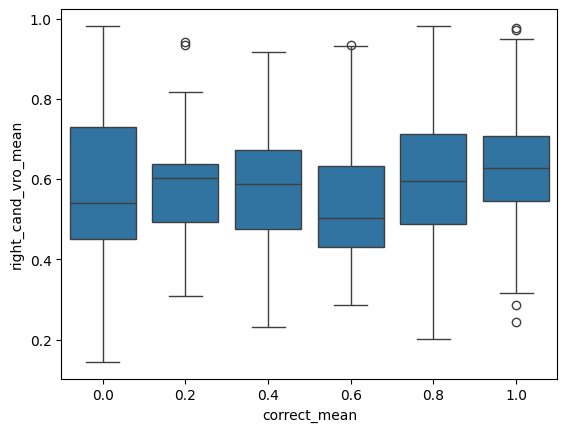

In [120]:
import seaborn as sns
sns.boxplot(data=aggro, y="right_cand_vro_mean", x="correct_mean")

<Axes: xlabel='correct_mean', ylabel='right_cand_mindist_mean'>

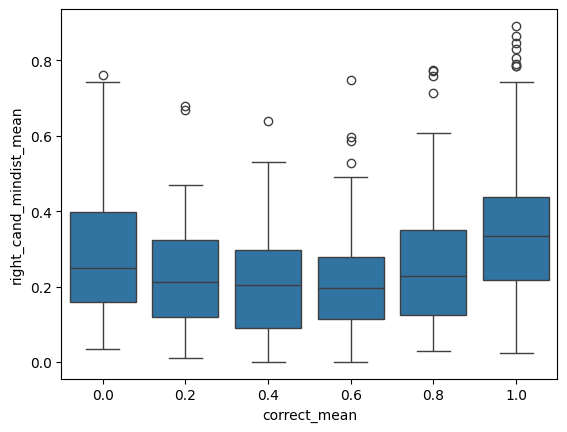

In [121]:
import seaborn as sns
sns.boxplot(data=aggro, y="right_cand_mindist_mean", x="correct_mean")

### entailment

In [2]:
DEVICE = "mps"

class BaseEntailment:
    def save_prediction_cache(self):
        pass


class EntailmentDeberta(BaseEntailment):
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xlarge-mnli")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "microsoft/deberta-v2-xlarge-mnli").to(DEVICE)

    def check_implication(self, text1, text2, *args, **kwargs):
        inputs = self.tokenizer(text1, text2, return_tensors="pt").to(DEVICE)
        # The model checks if text1 -> text2, i.e. if text2 follows from text1.
        # check_implication('The weather is good', 'The weather is good and I like you') --> 1
        # check_implication('The weather is good and I like you', 'The weather is good') --> 2
        outputs = self.model(**inputs)
        logits = outputs.logits
        # Deberta-mnli returns `neutral` and `entailment` classes at indices 1 and 2.
        largest_index = torch.argmax(F.softmax(logits, dim=1))  # pylint: disable=no-member
        prediction = largest_index.cpu().item()

        # print('Deberta Input: %s -> %s', text1, text2)
        # print('Deberta Prediction: %s', prediction)

        return prediction


In [3]:
model = EntailmentDeberta()

tokenizer_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.77G [00:00<?, ?B/s]

In [5]:
s1 = "today is sunny and when it is sunny I am happy"
s2 = "today I am happy"
model.check_implication(s1, s2)

2

In [ ]:
candidates = p['question'].split(',. What')[0].split('<')[1:]
candidates = [c.replace('>,', '').replace('>', '') for c in candidates]

In [ ]:
# TODO scatterplot cohesion (embeddings and/or implication) VS output variability